# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# magic word for producing visualizations in notebook
%matplotlib inline

from sklearn.preprocessing import Imputer
from sklearn.preprocessing import StandardScaler

from sklearn.decomposition import PCA

from sklearn.cluster import KMeans
import time

import warnings
warnings.filterwarnings('ignore')
from workspace_utils import active_session


### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', sep=';')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', sep=';')

In [3]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).

azdias.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [4]:
azdias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 85 columns):
AGER_TYP                 891221 non-null int64
ALTERSKATEGORIE_GROB     891221 non-null int64
ANREDE_KZ                891221 non-null int64
CJT_GESAMTTYP            886367 non-null float64
FINANZ_MINIMALIST        891221 non-null int64
FINANZ_SPARER            891221 non-null int64
FINANZ_VORSORGER         891221 non-null int64
FINANZ_ANLEGER           891221 non-null int64
FINANZ_UNAUFFAELLIGER    891221 non-null int64
FINANZ_HAUSBAUER         891221 non-null int64
FINANZTYP                891221 non-null int64
GEBURTSJAHR              891221 non-null int64
GFK_URLAUBERTYP          886367 non-null float64
GREEN_AVANTGARDE         891221 non-null int64
HEALTH_TYP               891221 non-null int64
LP_LEBENSPHASE_FEIN      886367 non-null float64
LP_LEBENSPHASE_GROB      886367 non-null float64
LP_FAMILIE_FEIN          886367 non-null float64
LP_FAMILIE_GROB          886367 n

In [5]:
azdias.shape

(891221, 85)

In [6]:
feat_info.shape

(85, 4)

In [7]:
feat_info.head()

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


In [8]:
feat_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85 entries, 0 to 84
Data columns (total 4 columns):
attribute             85 non-null object
information_level     85 non-null object
type                  85 non-null object
missing_or_unknown    85 non-null object
dtypes: object(4)
memory usage: 2.7+ KB


> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [9]:
# Identify missing or unknown data values and convert them to NaNs.
azdias.isnull().sum() #naturally missing data

AGER_TYP                      0
ALTERSKATEGORIE_GROB          0
ANREDE_KZ                     0
CJT_GESAMTTYP              4854
FINANZ_MINIMALIST             0
FINANZ_SPARER                 0
FINANZ_VORSORGER              0
FINANZ_ANLEGER                0
FINANZ_UNAUFFAELLIGER         0
FINANZ_HAUSBAUER              0
FINANZTYP                     0
GEBURTSJAHR                   0
GFK_URLAUBERTYP            4854
GREEN_AVANTGARDE              0
HEALTH_TYP                    0
LP_LEBENSPHASE_FEIN        4854
LP_LEBENSPHASE_GROB        4854
LP_FAMILIE_FEIN            4854
LP_FAMILIE_GROB            4854
LP_STATUS_FEIN             4854
LP_STATUS_GROB             4854
NATIONALITAET_KZ              0
PRAEGENDE_JUGENDJAHRE         0
RETOURTYP_BK_S             4854
SEMIO_SOZ                     0
SEMIO_FAM                     0
SEMIO_REL                     0
SEMIO_MAT                     0
SEMIO_VERT                    0
SEMIO_LUST                    0
                          ...  
OST_WEST

In [11]:
#total naturally missing
azdias.isnull().sum().sum()

4896838

In [12]:
#tot values
azdias.shape[0]*azdias.shape[1]

75753785

In [13]:
4896838/75753785 #proportion of natural missing

0.06464149613118342

In [14]:
feat_info.head()

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


In [15]:
#transform in array
feat_info['values'] = feat_info.missing_or_unknown.apply(lambda x: x[1:-1].split(',') )

In [16]:
feat_info['values'][0]

['-1', '0']

In [17]:
feat_info['missing_or_unknown'][0]

'[-1,0]'

In [17]:
#transform missing or unknown to NaN
df = azdias.copy()
index = 0

for column in df:
    df.where(~df.isin({column: feat_info['values'][index]}),np.nan,inplace=True)
    index+=1

In [18]:
#export df not to have to rerun the transformation again
export_csv = df.to_csv(r'export_dataframe.csv', index = None, header=True) 

In [32]:
df = pd.read_csv('export_dataframe.csv')

In [33]:
df.isnull().sum().sum()

8373929

In [34]:
8373929/75753785 #proportion of missing and unknown

0.1105413940702765

#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [35]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.

#proportion of missing values per column
null_counts = df.isnull().sum()/len(df)
null_counts.sort_values(ascending=False, inplace=True)

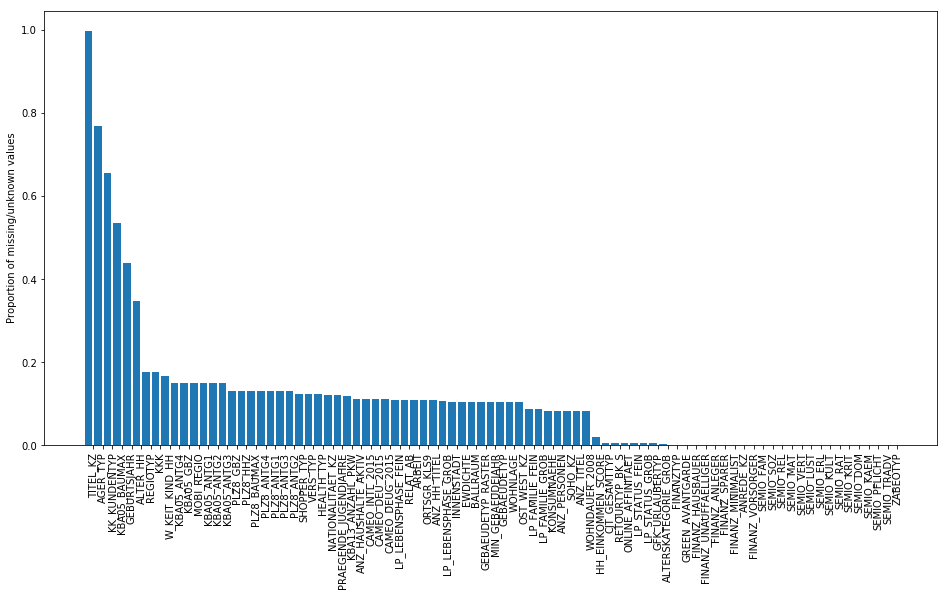

In [36]:
#visualise proportion of missing values per column
plt.figure(figsize=(16,8))
plt.xticks(np.arange(len(null_counts))+0.5,null_counts.index,rotation='vertical')
plt.ylabel('Proportion of missing/unknown values')
plt.bar(np.arange(len(null_counts)),null_counts);

In [37]:
# Investigate patterns in the amount of missing data in each column.
print(df[df['KBA05_ANTG1'].isnull()][['KBA05_ANTG1','KBA05_ANTG2', 'KBA05_ANTG3', 'KBA05_ANTG4']].shape[0])
df[df['KBA05_ANTG1'].isnull()][['KBA05_ANTG1','KBA05_ANTG2', 'KBA05_ANTG3', 'KBA05_ANTG4']].isnull().sum()

133324


KBA05_ANTG1    133324
KBA05_ANTG2    133324
KBA05_ANTG3    133324
KBA05_ANTG4    133324
dtype: int64

Whenever KBA05_ANTG1 has missing values also related columns have. In general we can see this pattern for columns of the same category. 

In [38]:
null_counts[null_counts>0.2]

TITEL_KZ        0.997576
AGER_TYP        0.769554
KK_KUNDENTYP    0.655967
KBA05_BAUMAX    0.534687
GEBURTSJAHR     0.440203
ALTER_HH        0.348137
dtype: float64

In [39]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)

#removing columns where more than 20% of the data is missing
df.drop(['TITEL_KZ', 'AGER_TYP', 'KK_KUNDENTYP','KBA05_BAUMAX','GEBURTSJAHR','ALTER_HH'],axis=1,inplace=True)

In [40]:
df.shape

(891221, 79)

#### Discussion 1.1.2: Assess Missing Data in Each Column

I removed six columns that had more than 20% of the data missing. These are:
- TITEL_KZ: Academic title flag
- AGER_TYP: Best-ager typology
- KK_KUNDENTYP: Consumer pattern over past 12 months
- KBA05_BAUMAX: Most common building type within the microcell
- GEBURTSJAHR: year of birth
- ALTER_HH: Birthdate of head of household

I have then investigated columns of the type *"KBA05_ANTG..."* and found out that once there is missing data in one of these columns there is missing data in all the others within the same type.

As an example, *PLZ8* columns seem to have the same pattern. 

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [41]:
# How much data is missing in each row of the dataset?
null_row = pd.DataFrame(np.sum(df.isnull(), axis=1).sort_values(ascending=False))

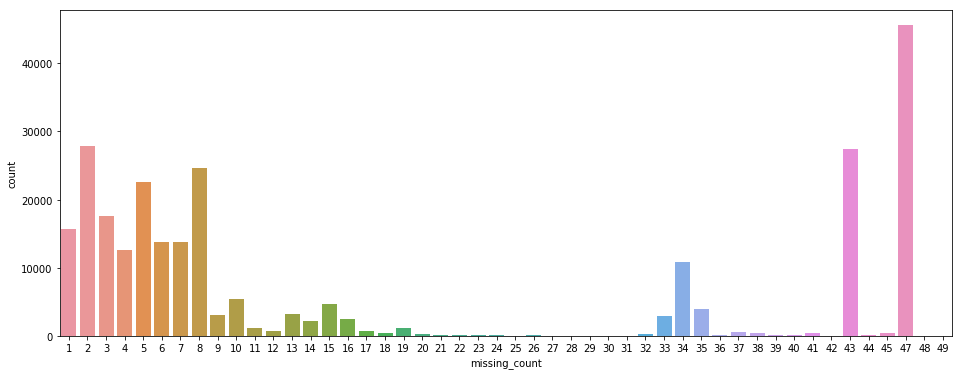

In [42]:
null_row.columns = ['missing_count']
null_row_zeros_out = null_row[null_row['missing_count']!=0]

fig = plt.figure(figsize=(16,6))
sns.countplot(data = null_row_zeros_out, x = 'missing_count');

In [49]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.

missing_df = df[np.sum(df.isnull(), axis=1) > 30]
clean_df = df[np.sum(df.isnull(), axis=1) < 31]


In [44]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.

#columns with no or few missing data
clean_columns_comparison = ['SEMIO_KAEM', 'FINANZ_MINIMALIST', 'GREEN_AVANTGARDE', 'ALTERSKATEGORIE_GROB', 
                            'LP_STATUS_FEIN']

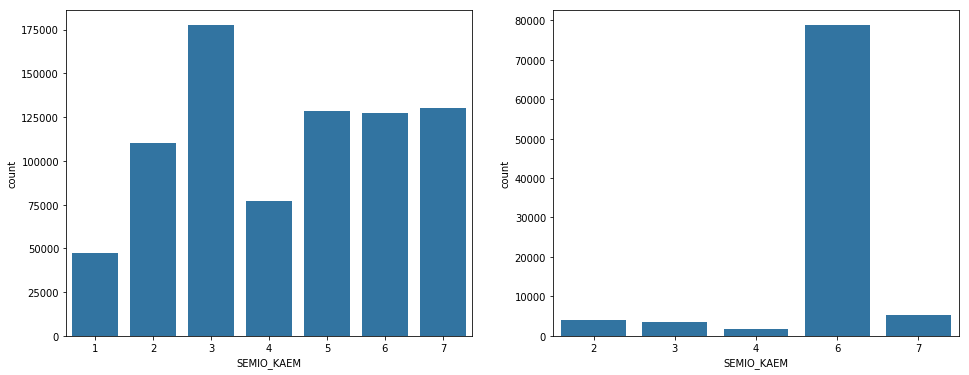

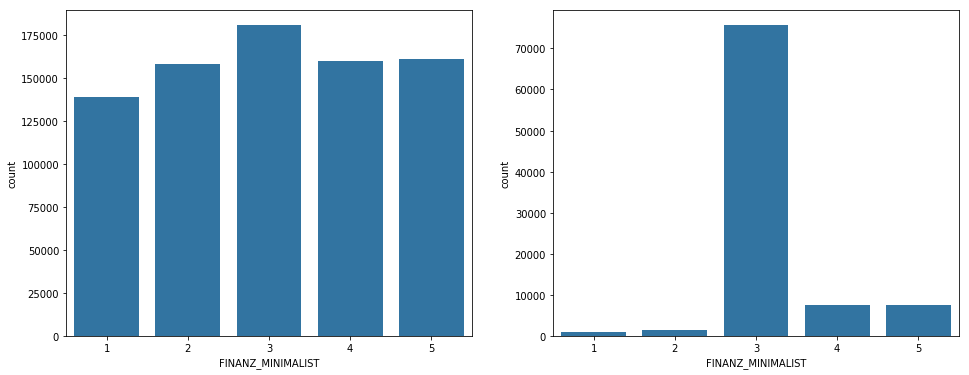

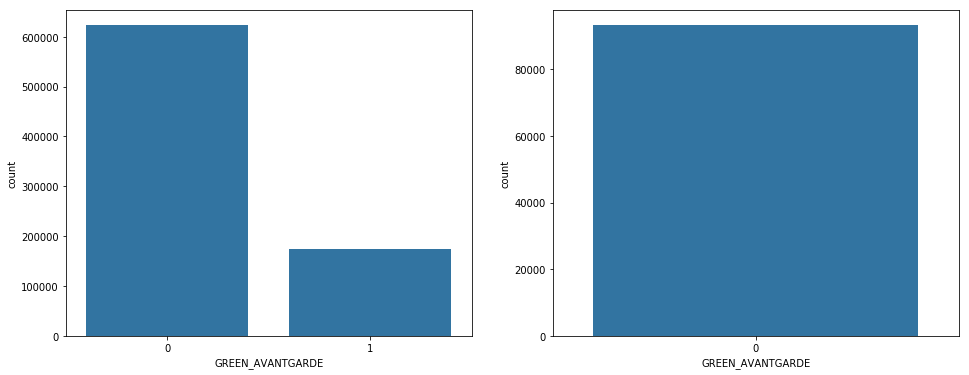

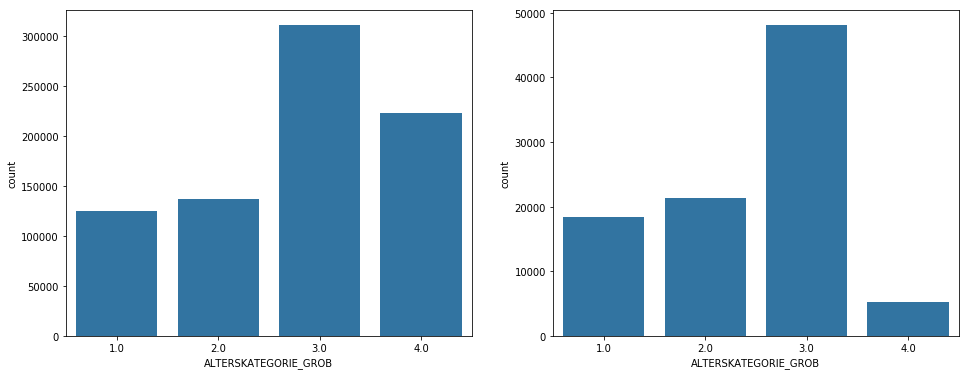

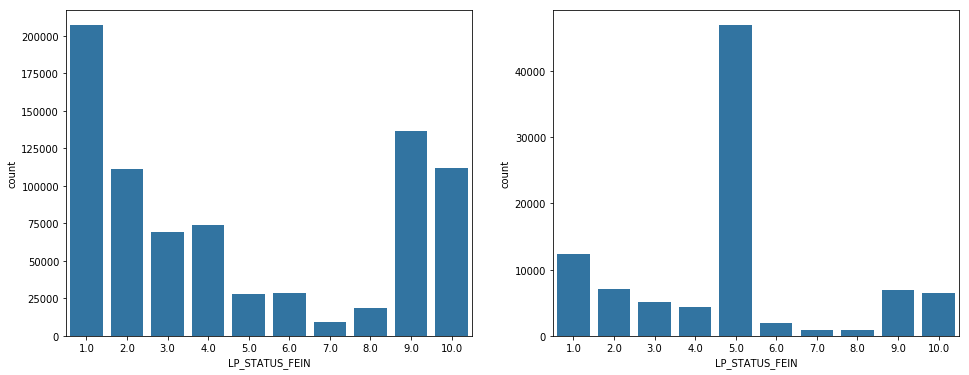

In [45]:
base = sns.color_palette()[0]

for column in clean_columns_comparison:
    fig = plt.figure(figsize=(16,6))
    fig.add_subplot(1, 2, 1)
    sns.countplot(x = column, data = clean_df, color=base)
    fig.add_subplot(1, 2, 2)
    sns.countplot(x = column, data = missing_df, color=base)

#### Discussion 1.1.3: Assess Missing Data in Each Row

The distribution of data for the 5 chosen columns differs between the dataframe with clean rows and the one with rows having more than 31 missing values. 
Either way, the analysis will continue with the clean data. 

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [46]:
# How many features are there of each data type?

feat_info.type.unique()

array(['categorical', 'ordinal', 'numeric', 'mixed', 'interval'], dtype=object)

In [47]:
feat_info[feat_info.type=='categorical']

,attribute,information_level,type,missing_or_unknown,values
0,AGER_TYP,person,categorical,"[-1,0]","[-1, 0]"
2,ANREDE_KZ,person,categorical,"[-1,0]","[-1, 0]"
3,CJT_GESAMTTYP,person,categorical,[0],[0]
10,FINANZTYP,person,categorical,[-1],[-1]
12,GFK_URLAUBERTYP,person,categorical,[],[]
13,GREEN_AVANTGARDE,person,categorical,[],[]
17,LP_FAMILIE_FEIN,person,categorical,[0],[0]
18,LP_FAMILIE_GROB,person,categorical,[0],[0]
19,LP_STATUS_FEIN,person,categorical,[0],[0]
20,LP_STATUS_GROB,person,categorical,[0],[0]


- AGER_TYP: we removed it
- ANREDE_KZ: representing gender, binary
- CJT_GESAMTTYP: Customer-Journey-Typology: preferred information and buying channels for
consumer
- FINANZTYP: Most descriptive financial type for individual
- GFK_URLAUBERTYP: vacation habits
- GREEN_AVANTGARDE: binary
- LP_FAMILIE_FEIN: Family type, fine scale
- LP_FAMILIE_GROB: Family type, rough scale
- LP_STATUS_FEIN: Social status, fine scale
- LP_STATUS_GROB: Social status, rough scale
- NATIONALITAET_KZ: Nationality based on given name analysis
- SHOPPER_TYP: Shopper typology
- SOHO_KZ: binary
- TITEL_KZ: we removed it
- VERS_TYP: binary
- ZABEOTYP: Energy consumption typology
- KK_KUNDENTYP: we removed it
- GEBAEUDETYP: Type of building (residential vs. commercial)
- OST_WEST_KZ: binary, non-numerical so re-encode
- CAMEO_DEUG_2015: German CAMEO: Wealth / Life Stage Typology, rough scale
- CAMEO_DEU_2015: too many non-numeric categories, remove

Remove also LP_STATUS_FEIN and LP_FAMILIE_FEIN as we can use rough scale that has fewer categories. 

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [48]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?

#drop columns
clean_df.drop(['CAMEO_DEU_2015','LP_STATUS_FEIN', 'LP_FAMILIE_FEIN'], axis=1, inplace=True)

In [49]:
# Re-encode categorical variable(s) to be kept in the analysis.

#OST_WEST_KZ
clean_df['OST_WEST_KZ'].replace('W', 0, inplace=True)
clean_df['OST_WEST_KZ'].replace('O', 1, inplace=True)

#### Discussion 1.2.1: Re-Encode Categorical Features

See above.

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [50]:
feat_info[feat_info.type=='mixed']

,attribute,information_level,type,missing_or_unknown,values
15,LP_LEBENSPHASE_FEIN,person,mixed,[0],[0]
16,LP_LEBENSPHASE_GROB,person,mixed,[0],[0]
22,PRAEGENDE_JUGENDJAHRE,person,mixed,"[-1,0]","[-1, 0]"
56,WOHNLAGE,building,mixed,[-1],[-1]
59,CAMEO_INTL_2015,microcell_rr4,mixed,"[-1,XX]","[-1, XX]"
64,KBA05_BAUMAX,microcell_rr3,mixed,"[-1,0]","[-1, 0]"
79,PLZ8_BAUMAX,macrocell_plz8,mixed,"[-1,0]","[-1, 0]"


- LP_LEBENSPHASE_FEIN: Life stage, fine scale. Remove, too many categories
- LP_LEBENSPHASE_GROB: Life stage, rough scale. Remove, too many categories
- PRAEGENDE_JUGENDJAHRE: Dominating movement of person's youth (avantgarde vs. mainstream; east vs. west)
- WOHNLAGE: Neighborhood quality (or rural flag)
- CAMEO_INTL_2015: German CAMEO: Wealth / Life Stage Typology, mapped to international code
- KBA05_BAUMAX: we removed it
- PLZ8_BAUMAX: Most common building type within the PLZ8 region

In [51]:
clean_df.drop(['LP_LEBENSPHASE_FEIN','LP_LEBENSPHASE_GROB'], axis =1, inplace=True)

In [52]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.

clean_df['Mainstream'] = 0 #default value
m_main = clean_df['PRAEGENDE_JUGENDJAHRE'].isin([2.0,4.0,6.0,7.0,9.0,11.0,13.0,15.0]) #avantgarde
clean_df['Mainstream'] = clean_df['Mainstream'].where(m_main, 1)


In [53]:
#variable for decade

# Create the dictionary 
decade_dictionary ={1 : 40, 2 : 40, 3 : 50, 4:50, 5:60, 6:60, 7:60, 8:70, 9:70, 10:80, 11:80, 12:80, 13: 80, 14:90, 
                    15:90} 
  
clean_df['Decade'] = clean_df['PRAEGENDE_JUGENDJAHRE'].map(decade_dictionary) 


In [54]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.

def cameo_wealth(x):
    if pd.isnull(x):
        return np.nan
    else:
        return int(str(x)[0])

def cameo_life(x):
    if pd.isnull(x):
        return np.nan
    else:
        return int(str(x)[1])
    
clean_df['Wealth'] = clean_df['CAMEO_INTL_2015'].apply(cameo_wealth)
clean_df['LifeStage'] = clean_df['CAMEO_INTL_2015'].apply(cameo_life)

In [55]:
#drop initial columns
clean_df.drop(['PRAEGENDE_JUGENDJAHRE','CAMEO_INTL_2015'], axis = 1, inplace=True)

#export 
clean_csv = clean_df.to_csv(r'clean_dataframe.csv', index = None, header=True) 

In [56]:
clean_df = pd.read_csv('clean_dataframe.csv')

#### Discussion 1.2.2: Engineer Mixed-Type Features

We removed the columns on life stage as that information can be found somewhere else. We also re-engineered two columns and derived two variables from each of them.

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [57]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)

clean_df.isnull().sum().sort_values(ascending=False)

KKK                      64910
REGIOTYP                 64910
W_KEIT_KIND_HH           59305
KBA05_GBZ                40170
KBA05_ANTG3              40170
MOBI_REGIO               40170
KBA05_ANTG2              40170
KBA05_ANTG4              40170
KBA05_ANTG1              40170
SHOPPER_TYP              36726
VERS_TYP                 36726
HEALTH_TYP               36726
NATIONALITAET_KZ         33923
LP_FAMILIE_GROB          31474
Decade                   28758
PLZ8_HHZ                 23361
PLZ8_BAUMAX              23361
PLZ8_ANTG4               23361
PLZ8_GBZ                 23361
PLZ8_ANTG2               23361
PLZ8_ANTG1               23361
PLZ8_ANTG3               23361
KBA13_ANZAHL_PKW         12647
ANZ_HAUSHALTE_AKTIV       6462
CAMEO_DEUG_2015           6201
Wealth                    6201
LifeStage                 6201
LP_STATUS_GROB            4749
GFK_URLAUBERTYP           4749
ONLINE_AFFINITAET         4749
RETOURTYP_BK_S            4749
CJT_GESAMTTYP             4749
ARBEIT  

I would remove other mixed/categorical features that have some missing values and many categories in order to simplify the analysis, such as:
- WOHNLAGE(mixed, ~19k missing and 9 categories)
- PLZ8_BAUMAX(mixed, 42396 missing and 5 categories)
- CAMEO_DEUG_2015(categorical, 25233 missing and 9 categories)

In [58]:
clean_df.drop(['WOHNLAGE','PLZ8_BAUMAX','CAMEO_DEUG_2015'], axis=1, inplace=True)

In [59]:
clean_df.shape

(798067, 73)

In [60]:
#export 
clean_csv = clean_df.to_csv(r'clean_dataframe.csv', index = None, header=True) 

In [65]:
clean_df = pd.read_csv('clean_dataframe.csv')

### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [4]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    #CHECK
    if df.shape[1]!=85:
        print('Attention,' 
              'number of columns different than original initial dataframe. Cleaning process might be wrong.')
    
    #PREPROCESSING
    
    #transform in array
    feat_info['values'] = feat_info.missing_or_unknown.apply(lambda x: x[1:-1].split(',') )
    
    
    #transform missing or unknown to NaN
    index = 0
    for column in df:
        df.where(~df.isin({column: feat_info['values'][index]}),np.nan,inplace=True)
        index+=1
     
    
    #REMOVING COLUMNS AND ROWS    
    
    #removing columns where more than 50% of the data is missing
    df.drop(['TITEL_KZ', 'AGER_TYP', 'KK_KUNDENTYP','KBA05_BAUMAX','GEBURTSJAHR', 'ALTER_HH'],axis=1,inplace=True)
    
    #removing rows with more than 50% of the data missing
    df = df[np.sum(df.isnull(), axis=1) < 31]
    
    
    #RE-ENCODING FEATURES
    
    #categorical features: remove FEIN columns as we have rough scale and remove CAMEO_DEU_2015 as there are 
    #too many non-numeric categories
    df.drop(['CAMEO_DEU_2015','LP_STATUS_FEIN', 'LP_FAMILIE_FEIN'], axis=1, inplace=True)
    
    #Re-encode OST_WEST_KZ
    df['OST_WEST_KZ'].replace('W', 0, inplace=True)
    df['OST_WEST_KZ'].replace('O', 1, inplace=True)
    
    #mixed features: remove the two below as they have too many categories
    df.drop(['LP_LEBENSPHASE_FEIN','LP_LEBENSPHASE_GROB'], axis =1, inplace=True)
    
    # Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables
    df['Mainstream'] = 0 #default value
    m_main = df['PRAEGENDE_JUGENDJAHRE'].isin([2.0,4.0,6.0,7.0,9.0,11.0,13.0,15.0]) #avantgarde
    df['Mainstream'] = df['Mainstream'].where(m_main, 1)
    
    decade_dictionary ={1 : 40, 2 : 40, 3 : 50, 4:50, 5:60, 6:60, 7:60, 8:70, 9:70, 10:80, 11:80, 12:80, 13: 80, 
                        14:90, 15:90} 
    df['Decade'] = df['PRAEGENDE_JUGENDJAHRE'].map(decade_dictionary) 
    
    #Investigate "CAMEO_INTL_2015" and engineer two new variables.
    def cameo_wealth(x):
        if pd.isnull(x):
            return np.nan
        else:
            return int(str(x)[0])

    def cameo_life(x):
        if pd.isnull(x):
            return np.nan
        else:
            return int(str(x)[1])
    
    df['Wealth'] = df['CAMEO_INTL_2015'].apply(cameo_wealth)
    df['LifeStage'] = df['CAMEO_INTL_2015'].apply(cameo_life)
    
    #Drop PRAEGENDE_JUGENDJAHRE and CAMEO_INTL_2015
    df.drop(['PRAEGENDE_JUGENDJAHRE','CAMEO_INTL_2015'], axis = 1, inplace=True)

    #Finally drop the columns below as they have too many missing values and categories
    df.drop(['WOHNLAGE','PLZ8_BAUMAX','CAMEO_DEUG_2015'], axis=1, inplace=True)
    
    # Return the cleaned dataframe.
    return df

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [66]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.

features = clean_df.copy()

#Imputer

#from sklearn.impute import SimpleImputer
imp = Imputer(missing_values=np.nan, strategy='median')
imputed_features = imp.fit_transform(features)

In [67]:
#scaling
scaler = StandardScaler()
scaled_features = scaler.fit_transform(imputed_features)

### Discussion 2.1: Apply Feature Scaling

First, since we have missing data I had to perform some operations before using the scaler function. Removing all the rows and columns with some missing data would give us a loss of valuable information and data points. Therefore, I used an Imputer. 

Then, I have used Standard Scaler as suggested and fit-transform the imputed features. 

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [65]:
# Apply PCA to the data.
pca = PCA()
pca_features = pca.fit_transform(scaled_features)

In [66]:
pca_features.shape

(798067, 73)

In [9]:
# Investigate the variance accounted for by each principal component.

#Function from Udacity lectures
def scree_plot(pca):
    '''
    Creates a scree plot associated with the principal components 
    
    INPUT: pca - the result of instantian of PCA in scikit learn
            
    OUTPUT:
            None
    '''
    num_components = len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
 
    plt.figure(figsize=(16, 6))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
    for i in range(num_components):
        ax.annotate(r"%s%%" % ((str(vals[i]*100)[:4])), (ind[i]+0.2, vals[i]), va="bottom", ha="center", fontsize=8)
 
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')


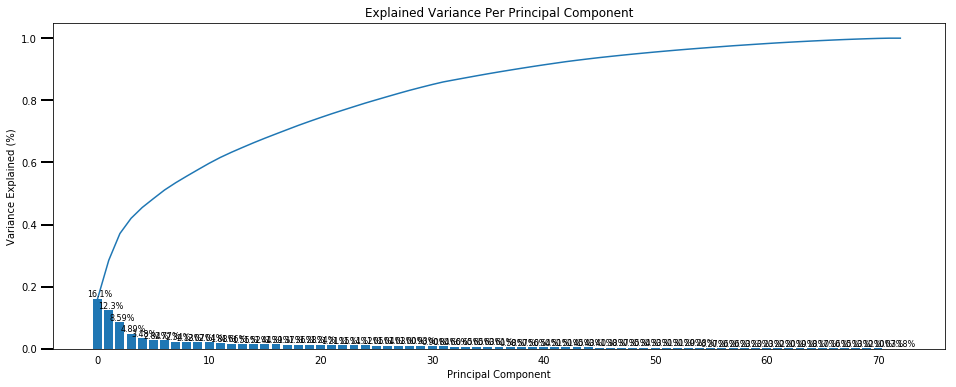

In [68]:
scree_plot(pca)

The image above tells us how much each component/feature explains the variability of the data. For instance, the first component explains 16.1% of the variability of the data. 



In [7]:
# Re-apply PCA to the data while selecting for number of components to retain.

pca = PCA(n_components = 50)
pca_features = pca.fit_transform(scaled_features)

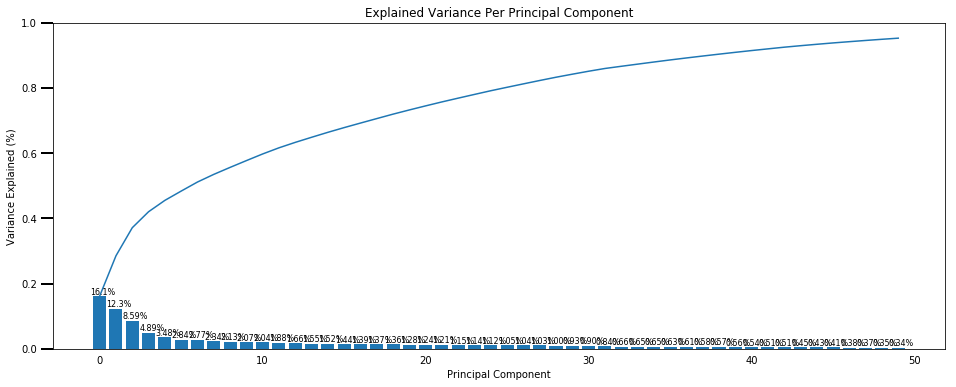

In [10]:
scree_plot(pca)

In [11]:
sum(pca.explained_variance_ratio_)

0.9520038432455874

### Discussion 2.2: Perform Dimensionality Reduction

From the above, we can see that we can re-run PCA with 50 components and get 95% of the variability of the data explained. 

We will therefore continue the project with this reduced dimensionality (from 73 features to 50).

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [72]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.

def pca_component(df,pca,n_component):
    selected_component = pd.DataFrame(np.round(pca.components_,4), columns = df.keys()).iloc[n_component - 1]
    selected_component.sort_values(ascending=False,inplace=True)
    summary = pd.concat([selected_component.head(5), selected_component.tail(5)])

    fig=plt.figure(figsize=(6,6))
    summary.plot(kind='bar', title='Component '+str(n_component),color='blue')
    ax = plt.gca()
    ax.grid(linewidth='0.5', alpha=0.5)
    ax.set_axisbelow(True)
    plt.show()

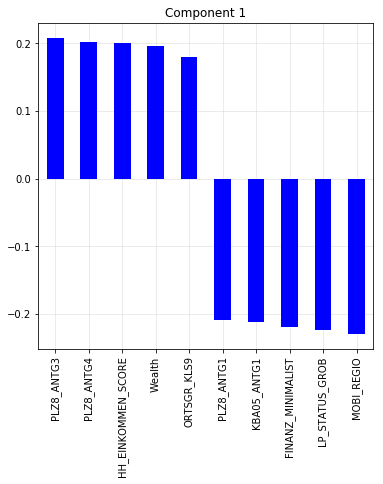

In [73]:
pca_component(clean_df, pca, 1)

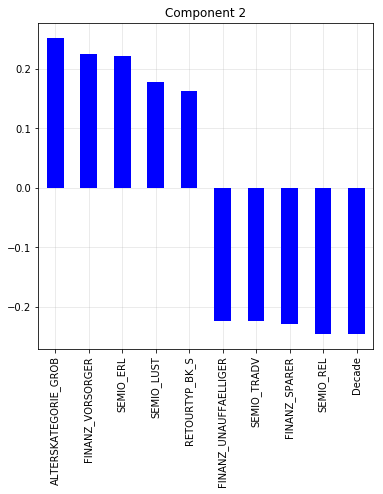

In [74]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.

pca_component(clean_df, pca,2)

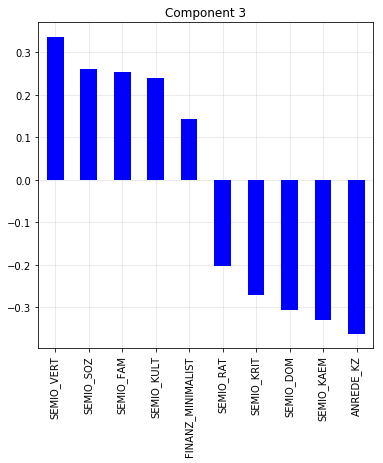

In [75]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.

pca_component(clean_df, pca,3)

### Discussion 2.3: Interpret Principal Components

The **first component** is mainly built upon the following features:
- PLZ8_ANTG3: Number of 6-10 family houses in the PLZ8 region
- HH_EINKOMMEN_SCORE: Estimated household income
- PLZ8_ANTG4: Number of 10+ family houses in the PLZ8 region
- Wealth: household wealth
- FINANZ_SPARER: money saver
- PLZ8_ANTG1: Number of 1-2 family houses in the PLZ8 region
- KBA05_ANTG1: Number of 1-2 family houses in the microcell
- LP_STATUS_GROB: social status, rough scale
- MOBI_REGIO: movement pattern
- FINANZ_MINIMALIST: low financial interest

Therefore, the first component seems to be associated with household size, financial and social status.

The **second component** is mainly derived from:
- ALTERSKATEGORIE_GROB: Estimated age based on given name analysis
- FINANZ_VORSORGER: be prepared (higher if very low)
- SEMIO_ERL: event-oriented (higher if low affinity)
- SEMIO_LUST: sensual-minded (higher if low affinity)
- RETOURTYP_BK_S: Return type (higher if minimal returner)
- SEMIO_TRADV: traditional-minded (higher if low affinity)
- FINANZ_SPARER: money saver (higher if very low)
- FINANZ_UNAUFFAELLIGER: incospicuous (higher if very low)
- SEMIO_REL: religious (higher if low affinity)
- Decade: decade of person youth

Therefore, the second component seems to be associated with age and financial behaviour.

The **third component** is mainly coming from:
- SEMIO_VERT: dreamful (higher if low affinity)
- SEMIO_FAM: family-minded (higher if low affinity)
- SEMIO_SOZ: socially-minded (higher if low affinity)
- SEMIO_KULT: cultural-minded (higher if low affinity)
- FINANZ_MINIMALIST: low financial interest (higher if very low)
- SEMIO_ERL: event-oriented (higher if low affinity)
- SEMIO_KRIT: critical-minded (higher if low affinity)
- SEMIO_DOM: dominant-minded (higher if low affinity)
- SEMIO_KAEM: combative attitude (higher if low affinity)
- ANREDE_KZ: gender

Therefore, the third component is associated with personality and gender. 

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [76]:
#had to split it as it was taking too long running

scores_1 = []
start = time.time()

# Over a number of different cluster counts...

with active_session():
    for center in list(range(1,19)):
        print('\nNumber of Centroids: {}.\n'.format(center))

        # run k-means clustering on the data and...
        kmeans = KMeans(n_clusters=center)
        model = kmeans.fit(pca_features)
        print('Model created.\n')

        # compute the average within-cluster distances.
        score = np.abs(model.score(pca_features))
        scores_1.append(score)

        print('Number of Centroids: {}, score: {}.\n'.format(center, round(score,2)))

end = time.time()
print(end-start)


Number of Centroids: 1.

Model created.

Number of Centroids: 1, score: 55462560.03.


Number of Centroids: 2.

Model created.

Number of Centroids: 2, score: 48396791.83.


Number of Centroids: 3.

Model created.

Number of Centroids: 3, score: 44832543.44.


Number of Centroids: 4.

Model created.

Number of Centroids: 4, score: 42660873.61.


Number of Centroids: 5.

Model created.

Number of Centroids: 5, score: 41191963.71.


Number of Centroids: 6.

Model created.

Number of Centroids: 6, score: 39853001.24.


Number of Centroids: 7.

Model created.

Number of Centroids: 7, score: 38682278.12.


Number of Centroids: 8.

Model created.

Number of Centroids: 8, score: 37756911.06.


Number of Centroids: 9.

Model created.

Number of Centroids: 9, score: 37141429.0.


Number of Centroids: 10.

Model created.

Number of Centroids: 10, score: 36385997.08.


Number of Centroids: 11.

Model created.

Number of Centroids: 11, score: 36103631.15.


Number of Centroids: 12.

Model created

KeyboardInterrupt: 

In [77]:
scores_1

[55462560.025095992,
 48396791.825691052,
 44832543.43857915,
 42660873.609849021,
 41191963.710378259,
 39853001.238723285,
 38682278.119323485,
 37756911.058238849,
 37141429.004573628,
 36385997.077023432,
 36103631.149446048,
 35365260.588634007,
 35306645.7594558,
 34653293.123172358,
 34351255.169439726,
 34118065.540083431,
 33308149.40747036,
 33185143.718825478]

In [21]:
#from 1 to 18 included

scores_1 = [55462560.025095992,
 48396791.825691052,
 44832543.43857915,
 42660873.609849021,
 41191963.710378259,
 39853001.238723285,
 38682278.119323485,
 37756911.058238849,
 37141429.004573628,
 36385997.077023432,
 36103631.149446048,
 35365260.588634007,
 35306645.7594558,
 34653293.123172358,
 34351255.169439726,
 34118065.540083431,
 33308149.40747036,
 33185143.718825478]

In [12]:
scores_2 = []
start = time.time()
# Over a number of different cluster counts...

with active_session():
    for center in list(range(19,23)):
        print('\nNumber of Centroids: {}.\n'.format(center))

        # run k-means clustering on the data and...
        kmeans = KMeans(n_clusters=center)
        model = kmeans.fit(pca_features)
        print('Model created.\n')

        # compute the average within-cluster distances.
        score = np.abs(model.score(pca_features))
        scores_2.append(score)

        print('Number of Centroids: {}, score: {}.\n'.format(center, round(score,2)))

end = time.time()
print(end-start)


Number of Centroids: 19.

Model created.

Number of Centroids: 19, score: 33012942.34.


Number of Centroids: 20.

Model created.

Number of Centroids: 20, score: 32660630.64.


Number of Centroids: 21.

Model created.

Number of Centroids: 21, score: 32638381.81.


Number of Centroids: 22.

Model created.

Number of Centroids: 22, score: 32268307.23.

2082.5103380680084


In [13]:
scores_2

[33012942.339706503,
 32660630.641483538,
 32638381.805289544,
 32268307.232216913]

In [20]:
scores_2 = [33012942.339706503,
 32660630.641483538,
 32638381.805289544,
 32268307.232216913]

In [17]:
scores_3 = []
start = time.time()
# Over a number of different cluster counts...

with active_session():
    for center in list(range(23,31)):
        print('\nNumber of Centroids: {}.\n'.format(center))

        # run k-means clustering on the data and...
        kmeans = KMeans(n_clusters=center)
        model = kmeans.fit(pca_features)
        print('Model created.\n')

        # compute the average within-cluster distances.
        score = np.abs(model.score(pca_features))
        scores_3.append(score)

        print('Number of Centroids: {}, score: {}.\n'.format(center, round(score,2)))

end = time.time()
time_run = (end-start)/60
print(np.round(time_run,2),'mins')


Number of Centroids: 23.

Model created.

Number of Centroids: 23, score: 31968220.47.


Number of Centroids: 24.

Model created.

Number of Centroids: 24, score: 31862199.41.


Number of Centroids: 25.

Model created.

Number of Centroids: 25, score: 31442483.76.


Number of Centroids: 26.

Model created.

Number of Centroids: 26, score: 31276614.55.


Number of Centroids: 27.

Model created.

Number of Centroids: 27, score: 30982316.49.


Number of Centroids: 28.

Model created.

Number of Centroids: 28, score: 30839164.12.


Number of Centroids: 29.

Model created.

Number of Centroids: 29, score: 30715127.82.


Number of Centroids: 30.

Model created.

Number of Centroids: 30, score: 30596160.22.

99.32 mins


In [18]:
scores_3

[31968220.466993056,
 31862199.406454753,
 31442483.75556314,
 31276614.546390243,
 30982316.490675773,
 30839164.118069019,
 30715127.820626836,
 30596160.218394425]

In [19]:
scores_3 = [31968220.466993056,
 31862199.406454753,
 31442483.75556314,
 31276614.546390243,
 30982316.490675773,
 30839164.118069019,
 30715127.820626836,
 30596160.218394425]

In [22]:
final_scores = scores_1 + scores_2 + scores_3

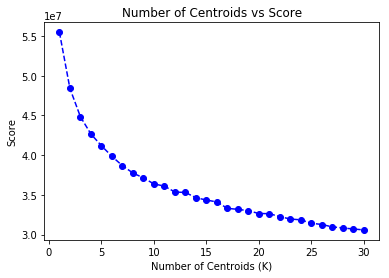

In [23]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.

plt.plot(list(range(1,31)), final_scores, linestyle='--', marker = 'o', color = 'b')
plt.xlabel('Number of Centroids (K)')
plt.ylabel('Score')
plt.title('Number of Centroids vs Score');

In [24]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.

clusters = 15

kmeans = KMeans(n_clusters=clusters)
model = kmeans.fit(pca_features)
labels = model.predict(pca_features)


### Discussion 3.1: Apply Clustering to General Population

In the plot "Number of Centroids vs Score" there isn't a clear elbow, however we can see that from 15 clusters onwards the error decreases at a much slower rate. 

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [25]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', sep = ';')

In [26]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.

#cleaning
clean_customers = clean_data(customers)

#imputing
customer_features = clean_customers.copy()
imputed_customer_features = imp.transform(customer_features)

In [27]:
#scaling
scaled_customer_features = scaler.transform(imputed_customer_features)

In [28]:
#pca
pca_customer_features = pca.transform(scaled_customer_features)

In [29]:
#clustering
customer_labels = model.predict(pca_customer_features)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

In [56]:
# additional data cluster for data took out previously for GENERAL POPULATION
labels = np.append(labels,[-1]*missing_df.shape[0])

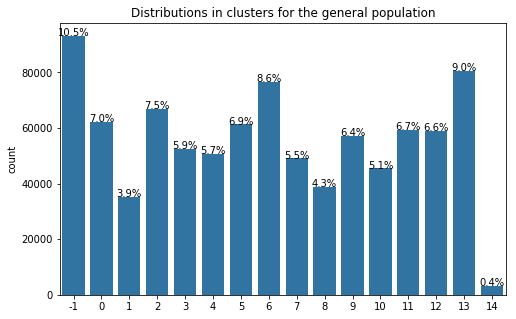

In [57]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.

#general population
base = sns.color_palette()[0]
total = len(labels)

fig = plt.figure(figsize = (8,5))
ax = sns.countplot(labels, color = base)

for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.1%}'.format(height/total),
            ha="center") 
plt.title('Distributions in clusters for the general population')
plt.show();

In [60]:
# additional data cluster for data took out previously for CUSTOMERS

missing_df_customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', sep = ';')

#transform in array
feat_info['values'] = feat_info.missing_or_unknown.apply(lambda x: x[1:-1].split(',') )
     
#transform missing or unknown to NaN
index = 0
for column in missing_df_customers:
    missing_df_customers.where(~missing_df_customers.isin({column: feat_info['values'][index]}),np.nan,inplace=True)
    index+=1
     
#REMOVING COLUMNS AND ROWS    
    
#removing columns where more than 50% of the data is missing
missing_df_customers.drop(['TITEL_KZ', 'AGER_TYP', 'KK_KUNDENTYP','KBA05_BAUMAX','GEBURTSJAHR', 'ALTER_HH'],axis=1,
                          inplace=True)
    
#removing rows with more than 50% of the data missing
missing_df_customers = missing_df_customers[np.sum(missing_df_customers.isnull(), axis=1) > 30]
    
customer_labels = np.append(customer_labels,[-1]*missing_df_customers.shape[0])

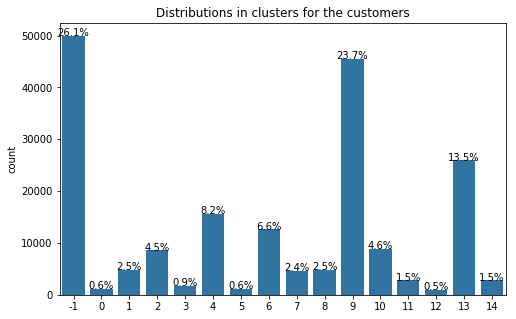

In [61]:
#customers
total_customers = len(customer_labels)

fig = plt.figure(figsize = (8,5))
ax_c = sns.countplot(customer_labels, color = base)

for p in ax_c.patches:
    height = p.get_height()
    ax_c.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.1%}'.format(height/total_customers),
            ha="center") 
plt.title('Distributions in clusters for the customers')
plt.show();

Here, we can see that the two distributions are quite different. 

We have clusters that are well-represented, ie there is a similar proportion of population and customers (clusters 10). 

Then clusters with a bigger proportion in the general population rather than the customer data, hence these are not the target demographics (clusters 0,1,2,3,5,6,7,8,11,12). 

Finally, the target audience for the company, ie where we see a greater proportion in the customer data rather than the general population (clusters -1,4,9,13,14).

Particular attention should be given to cluster 9 as that represents almost a third of the customer base.

In [68]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?

#cluster 9
pca_cluster_over = pca_features[labels==9]
inverse_pca_over = pca.inverse_transform(pca_cluster_over)
inverse_features_over = scaler.inverse_transform(inverse_pca_over)

features_cluster_over = pd.DataFrame(np.round(inverse_features_over), columns = clean_df.columns)

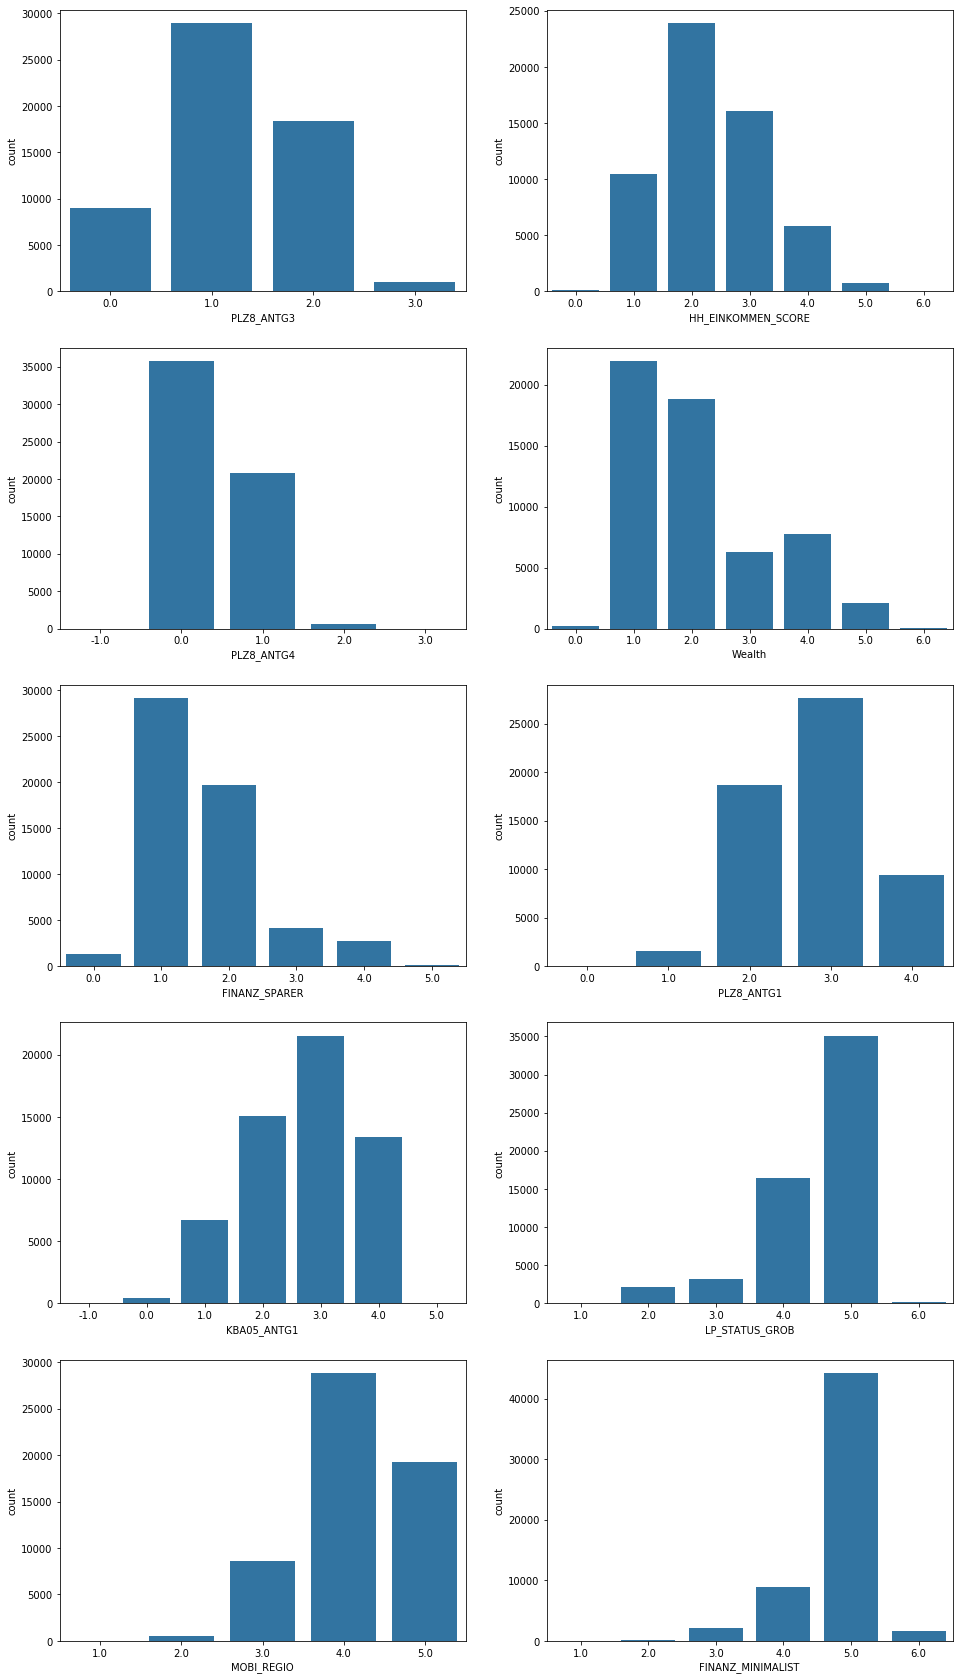

In [69]:
#first component
fig, axs = plt.subplots(5,2, figsize=(16,30))
sns.countplot(features_cluster_over['PLZ8_ANTG3'], ax = axs[0,0], color = base)
sns.countplot(features_cluster_over['HH_EINKOMMEN_SCORE'], ax = axs[0,1], color = base)
sns.countplot(features_cluster_over['PLZ8_ANTG4'], ax = axs[1,0], color = base)
sns.countplot(features_cluster_over['Wealth'], ax = axs[1,1], color = base)
sns.countplot(features_cluster_over['FINANZ_SPARER'], ax = axs[2,0], color = base)
sns.countplot(features_cluster_over['PLZ8_ANTG1'], ax = axs[2,1], color = base)
sns.countplot(features_cluster_over['KBA05_ANTG1'], ax = axs[3,0], color = base)
sns.countplot(features_cluster_over['LP_STATUS_GROB'], ax = axs[3,1], color = base)
sns.countplot(features_cluster_over['MOBI_REGIO'], ax = axs[4,0], color = base)
sns.countplot(features_cluster_over['FINANZ_MINIMALIST'], ax = axs[4,1], color = base)
plt.show();

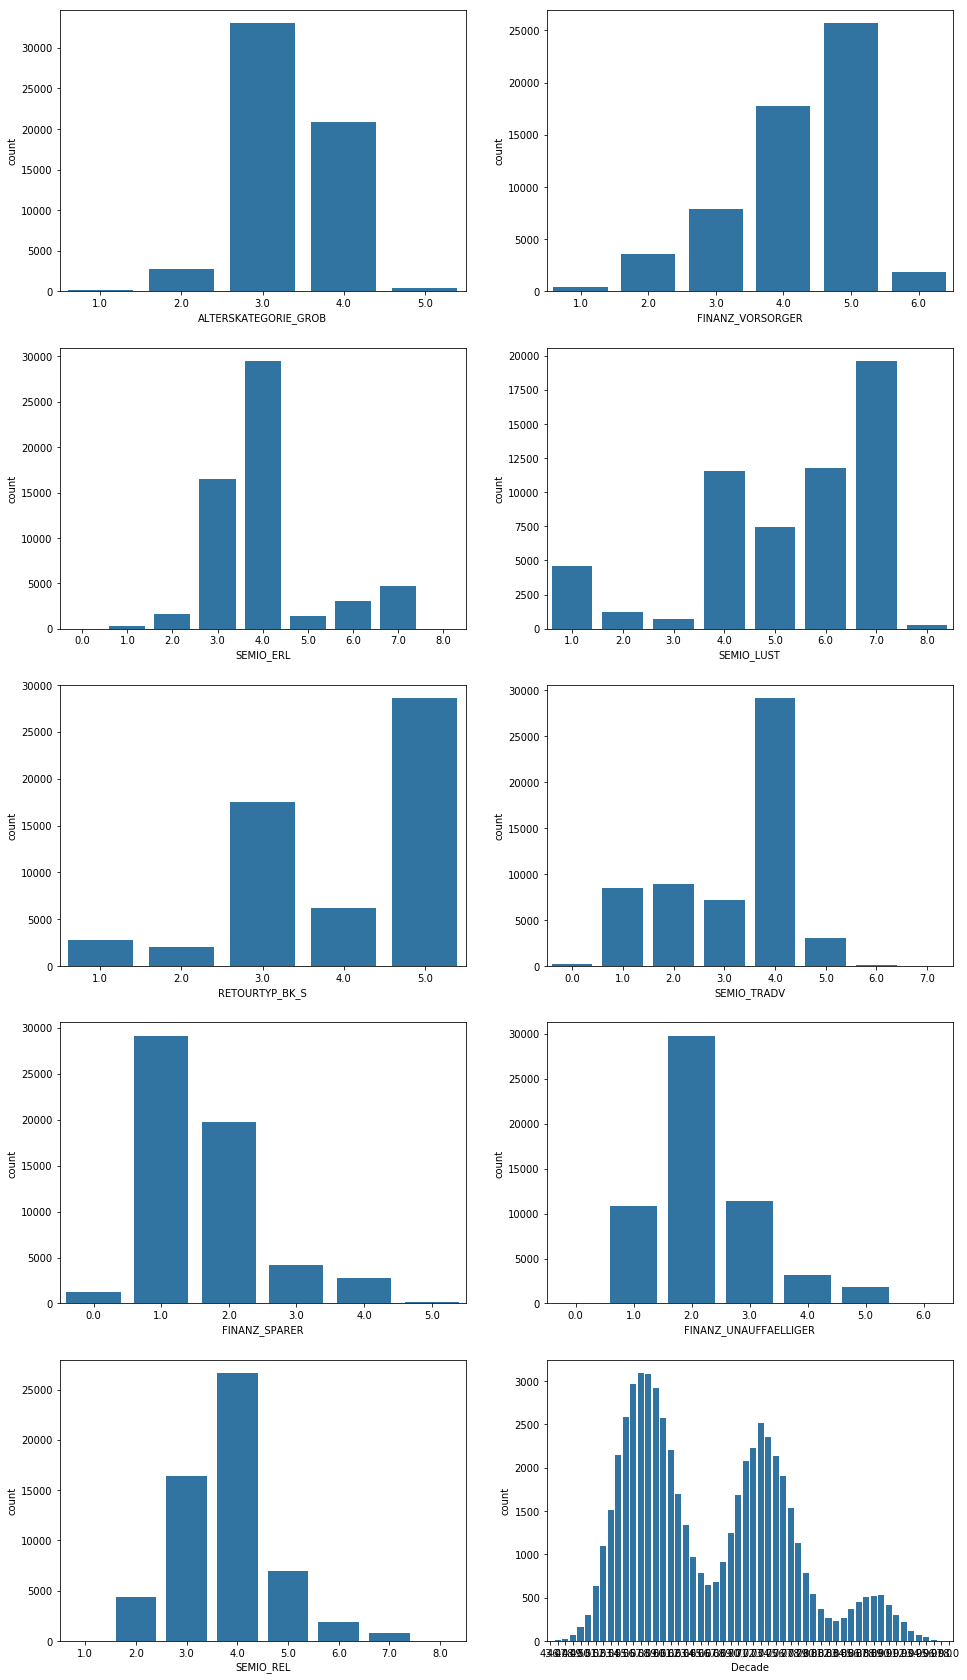

In [70]:
#second component
fig, axs = plt.subplots(5,2, figsize=(16,30))
sns.countplot(features_cluster_over['ALTERSKATEGORIE_GROB'], ax = axs[0,0], color = base)
sns.countplot(features_cluster_over['FINANZ_VORSORGER'], ax = axs[0,1], color = base)
sns.countplot(features_cluster_over['SEMIO_ERL'], ax = axs[1,0], color = base)
sns.countplot(features_cluster_over['SEMIO_LUST'], ax = axs[1,1], color = base)
sns.countplot(features_cluster_over['RETOURTYP_BK_S'], ax = axs[2,0], color = base)
sns.countplot(features_cluster_over['SEMIO_TRADV'], ax = axs[2,1], color = base)
sns.countplot(features_cluster_over['FINANZ_SPARER'], ax = axs[3,0], color = base)
sns.countplot(features_cluster_over['FINANZ_UNAUFFAELLIGER'], ax = axs[3,1], color = base)
sns.countplot(features_cluster_over['SEMIO_REL'], ax = axs[4,0], color = base)
sns.countplot(features_cluster_over['Decade'], ax = axs[4,1], color = base)
plt.show();

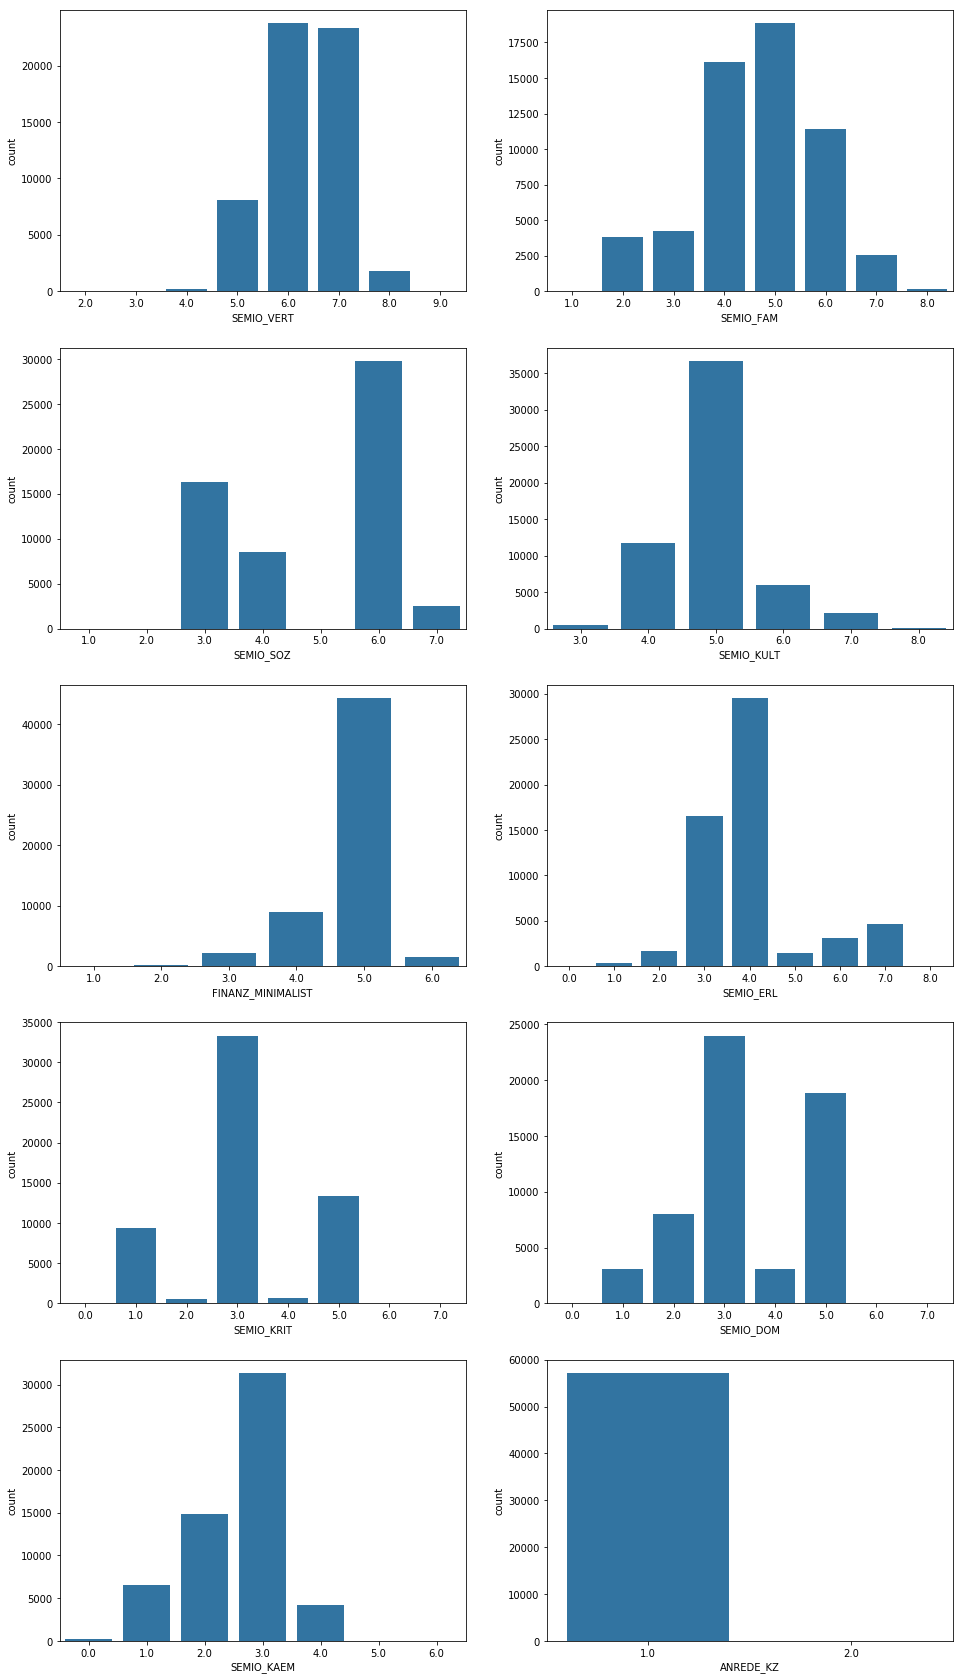

In [71]:
#third component
fig, axs = plt.subplots(5,2, figsize=(16,30))
sns.countplot(features_cluster_over['SEMIO_VERT'], ax = axs[0,0], color = base)
sns.countplot(features_cluster_over['SEMIO_FAM'], ax = axs[0,1], color = base)
sns.countplot(features_cluster_over['SEMIO_SOZ'], ax = axs[1,0], color = base)
sns.countplot(features_cluster_over['SEMIO_KULT'], ax = axs[1,1], color = base)
sns.countplot(features_cluster_over['FINANZ_MINIMALIST'], ax = axs[2,0], color = base)
sns.countplot(features_cluster_over['SEMIO_ERL'], ax = axs[2,1], color = base)
sns.countplot(features_cluster_over['SEMIO_KRIT'], ax = axs[3,0], color = base)
sns.countplot(features_cluster_over['SEMIO_DOM'], ax = axs[3,1], color = base)
sns.countplot(features_cluster_over['SEMIO_KAEM'], ax = axs[4,0], color = base)
sns.countplot(features_cluster_over['ANREDE_KZ'], ax = axs[4,1], color = base)
plt.show();

Cluster 9 accounts for 6.4% of the population.

Looking at the variables making up the first principal component, we can see this cluster is represented by:
- wealthy households with very high income (top earners)
- higher share of 1-2 family houses rather than 6-10 or 10+
- money savers with high financial interest

As for the second principal component:
- 46-60 years old
- determined minimal returner
- not sensual-minded

Finally, looking at the third component we gather that people in this cluster are:
- not very dreamful or socially-minded but rather critical-minded, with a combative and dominant attitude
- basically all male

In [72]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?

#Cluster 12
pca_cluster_under = pca_features[labels==12]
inverse_pca_under = pca.inverse_transform(pca_cluster_under)
inverse_features_under = scaler.inverse_transform(inverse_pca_under)
features_cluster_under = pd.DataFrame(np.round(inverse_features_under), columns = clean_df.columns)

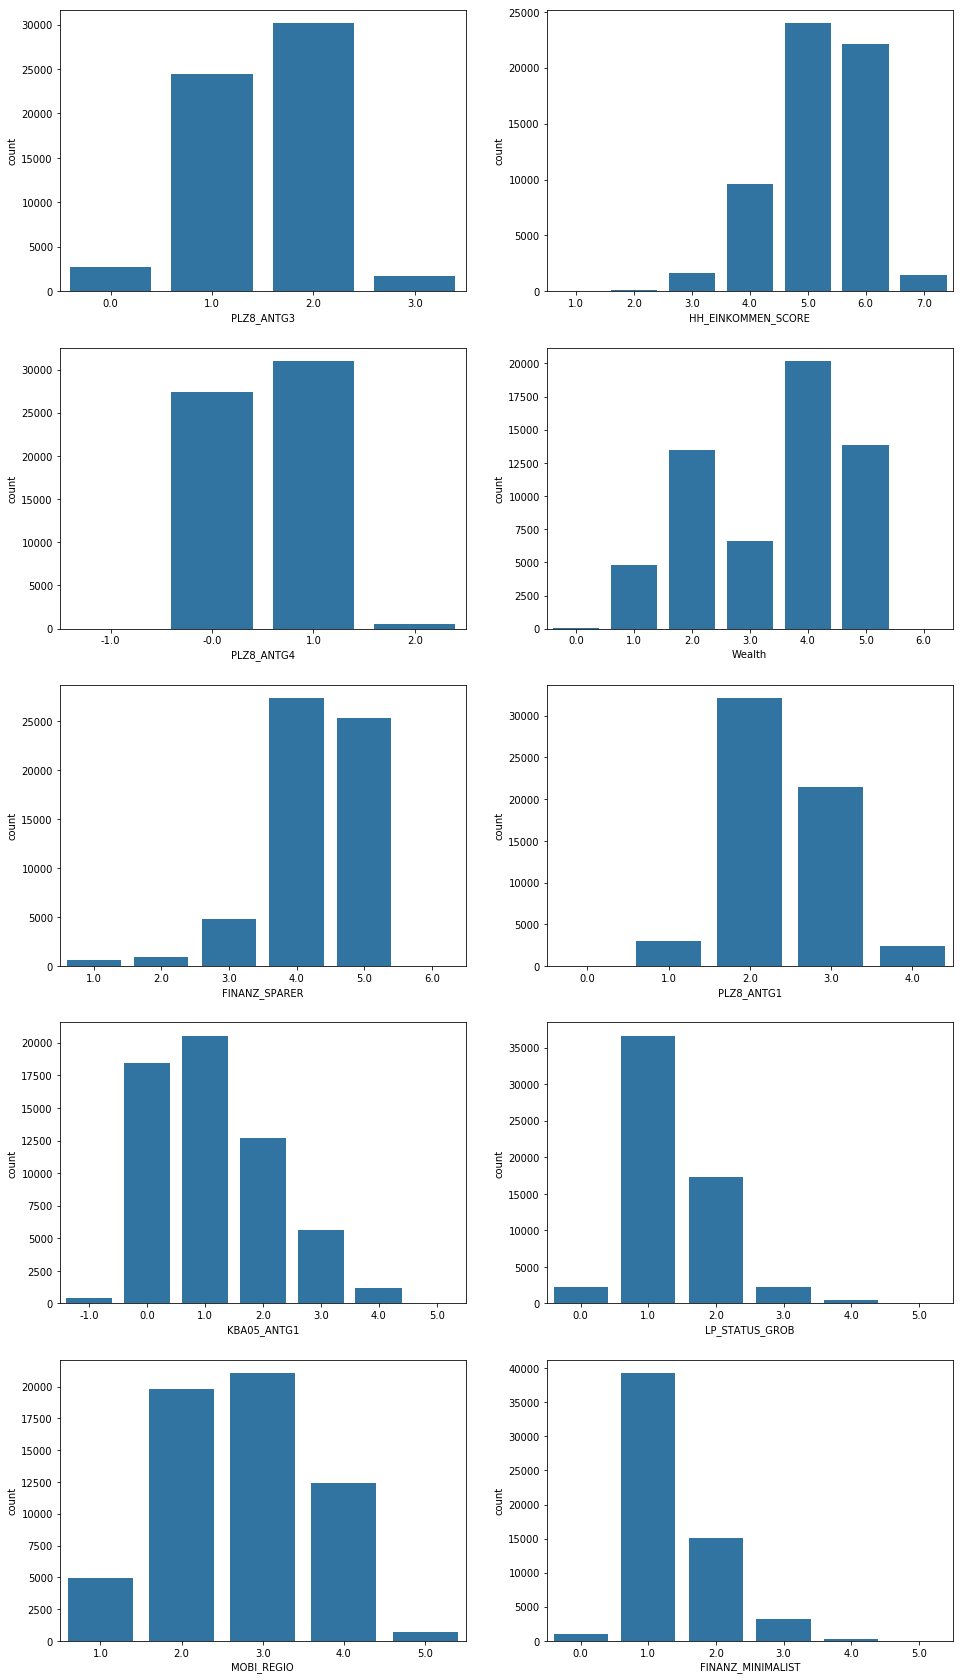

In [73]:
#first component
fig, axs = plt.subplots(5,2, figsize=(16,30))
sns.countplot(features_cluster_under['PLZ8_ANTG3'], ax = axs[0,0], color = base)
sns.countplot(features_cluster_under['HH_EINKOMMEN_SCORE'], ax = axs[0,1], color = base)
sns.countplot(features_cluster_under['PLZ8_ANTG4'], ax = axs[1,0], color = base)
sns.countplot(features_cluster_under['Wealth'], ax = axs[1,1], color = base)
sns.countplot(features_cluster_under['FINANZ_SPARER'], ax = axs[2,0], color = base)
sns.countplot(features_cluster_under['PLZ8_ANTG1'], ax = axs[2,1], color = base)
sns.countplot(features_cluster_under['KBA05_ANTG1'], ax = axs[3,0], color = base)
sns.countplot(features_cluster_under['LP_STATUS_GROB'], ax = axs[3,1], color = base)
sns.countplot(features_cluster_under['MOBI_REGIO'], ax = axs[4,0], color = base)
sns.countplot(features_cluster_under['FINANZ_MINIMALIST'], ax = axs[4,1], color = base)
plt.show()

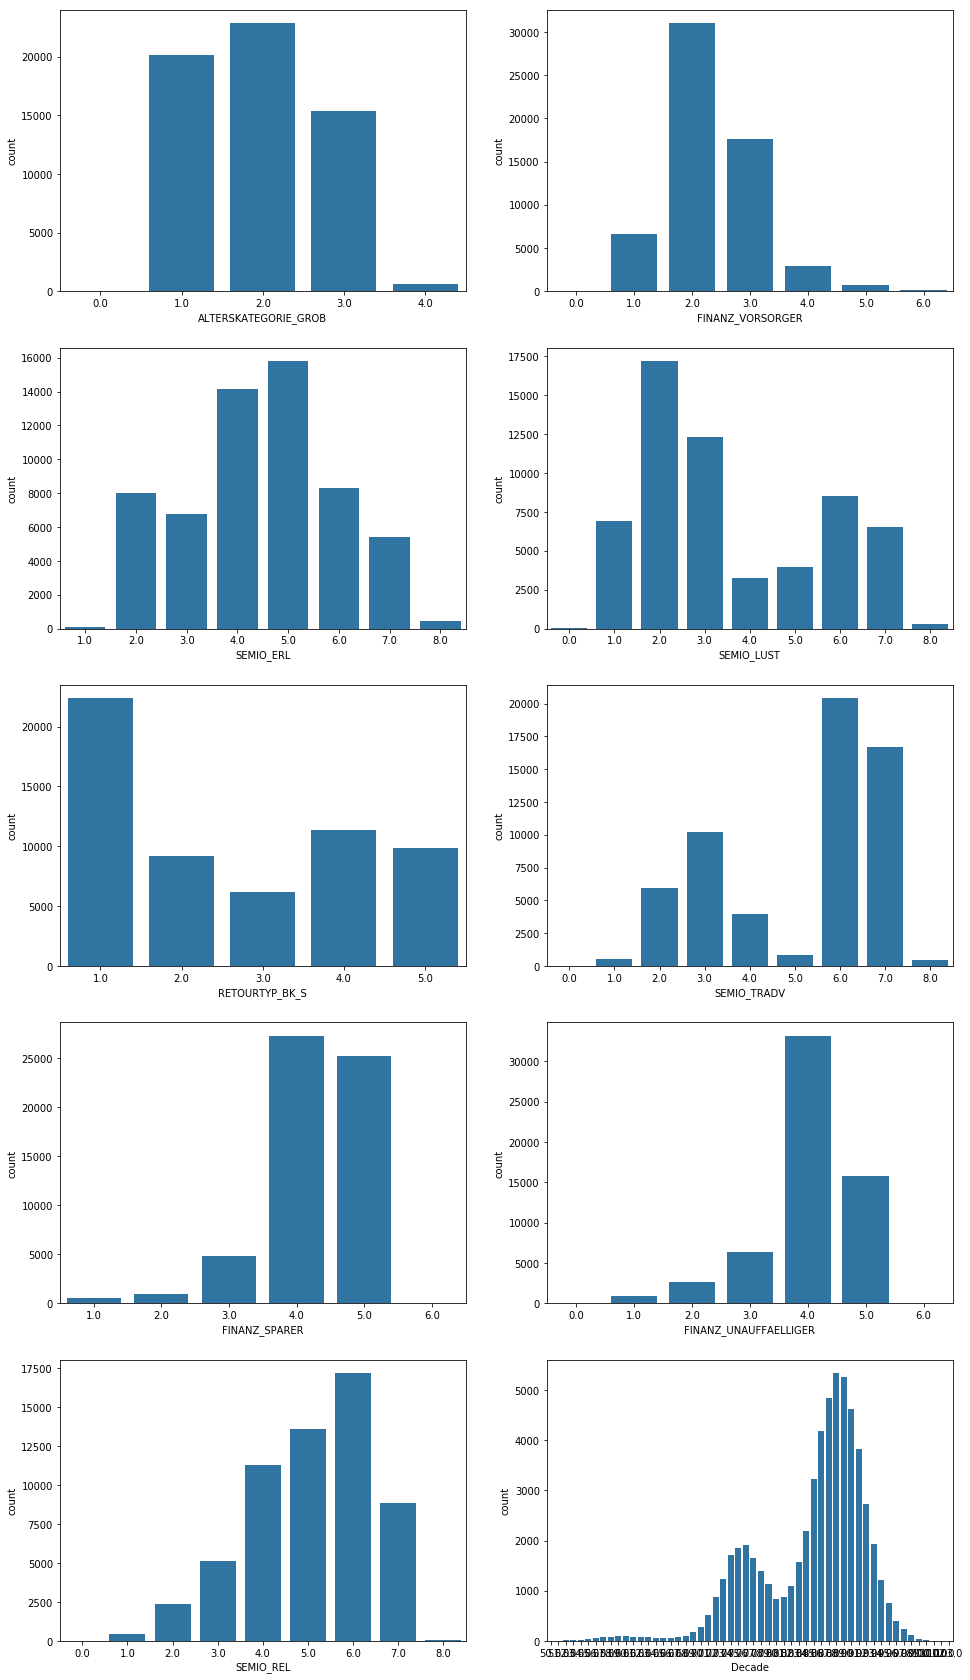

In [74]:
#second component
fig, axs = plt.subplots(5,2, figsize=(16,30))
sns.countplot(features_cluster_under['ALTERSKATEGORIE_GROB'], ax = axs[0,0], color = base)
sns.countplot(features_cluster_under['FINANZ_VORSORGER'], ax = axs[0,1], color = base)
sns.countplot(features_cluster_under['SEMIO_ERL'], ax = axs[1,0], color = base)
sns.countplot(features_cluster_under['SEMIO_LUST'], ax = axs[1,1], color = base)
sns.countplot(features_cluster_under['RETOURTYP_BK_S'], ax = axs[2,0], color = base)
sns.countplot(features_cluster_under['SEMIO_TRADV'], ax = axs[2,1], color = base)
sns.countplot(features_cluster_under['FINANZ_SPARER'], ax = axs[3,0], color = base)
sns.countplot(features_cluster_under['FINANZ_UNAUFFAELLIGER'], ax = axs[3,1], color = base)
sns.countplot(features_cluster_under['SEMIO_REL'], ax = axs[4,0], color = base)
sns.countplot(features_cluster_under['Decade'], ax = axs[4,1], color = base)
plt.show();

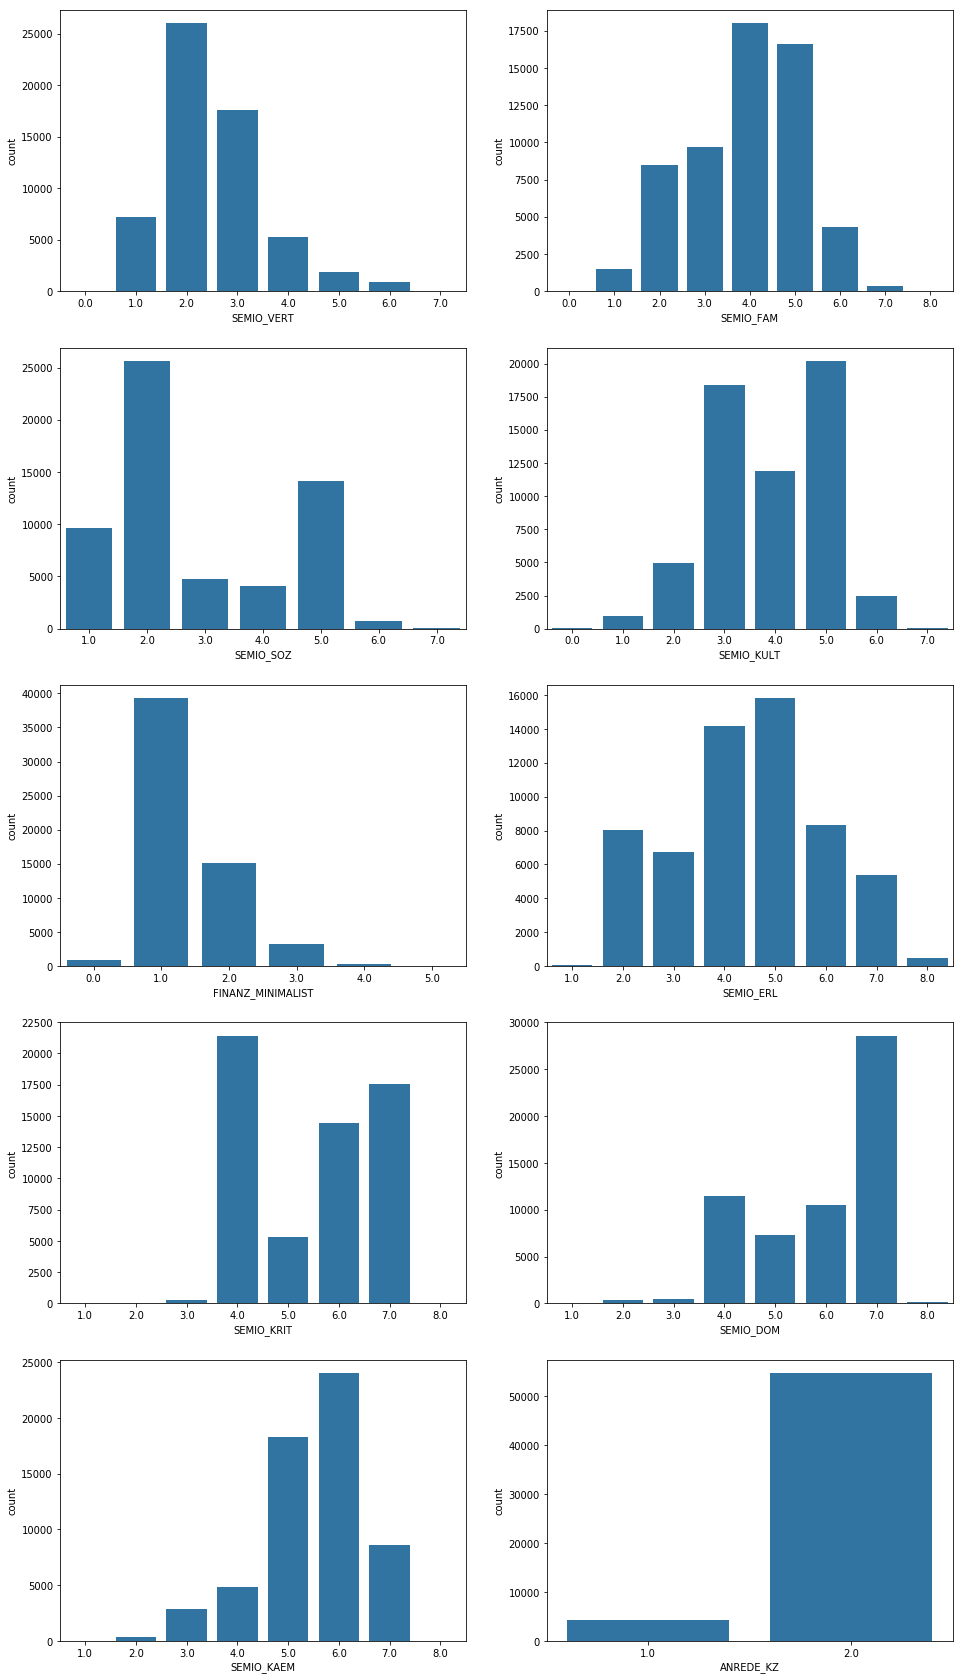

In [75]:
#third component
fig, axs = plt.subplots(5,2, figsize=(16,30))
sns.countplot(features_cluster_under['SEMIO_VERT'], ax = axs[0,0], color = base)
sns.countplot(features_cluster_under['SEMIO_FAM'], ax = axs[0,1], color = base)
sns.countplot(features_cluster_under['SEMIO_SOZ'], ax = axs[1,0], color = base)
sns.countplot(features_cluster_under['SEMIO_KULT'], ax = axs[1,1], color = base)
sns.countplot(features_cluster_under['FINANZ_MINIMALIST'], ax = axs[2,0], color = base)
sns.countplot(features_cluster_under['SEMIO_ERL'], ax = axs[2,1], color = base)
sns.countplot(features_cluster_under['SEMIO_KRIT'], ax = axs[3,0], color = base)
sns.countplot(features_cluster_under['SEMIO_DOM'], ax = axs[3,1], color = base)
sns.countplot(features_cluster_under['SEMIO_KAEM'], ax = axs[4,0], color = base)
sns.countplot(features_cluster_under['ANREDE_KZ'], ax = axs[4,1], color = base)
plt.show();

Cluster 12 makes up for 6.6% of the general population. 

From the first component we see that this subset of the population is made up of low-income earners with low financial interest, high movement and big family homes. 

Generally it's a younger subset (30-45 years old), not traditional- or religious-minded and not money saver. 

As for the last component, this shows us that most of this subset is represented by women, having a dreamful, non-combative, non-dominant and non-critical attitude.

### Discussion 3.3: Compare Customer Data to Demographics Data

(See also comments above)

The group that represents almost a third of the customer base is made up of upper-class mature (age 46-60 yrs) men having financial interest and a dominant attitude, who live mainly in smaller households.

The group that is the least represented is made of dreamful women living in bigger households and having a low income and financial interest.

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.